# Plots for the Teachable Robot Project

In [94]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from matplotlib.pyplot import cm
import matplotlib.lines as mlines


In [151]:
data_dirs = [
    pathlib.Path('meta-mb-internal/data'),
    pathlib.Path('meta-mb-internal/old_data'),
    pathlib.Path('meta-mb-internal'),
]

def get_filenames(name):
    name = str(name)
    name_paths = []
    for data_dir in data_dirs:
        for exp_dir in data_dir.iterdir():
            if name in exp_dir.name:
                name_paths.append(exp_dir)
    return name_paths

def load_data(name):
    name_paths = get_filenames(name)
    assert len(name_paths) > 0, "No files found with name " + name
    # check that they're all the same except the seed
    csv_datas = []
    for path in name_paths:
        assert path.name[:-1] == name_paths[0].name[:-1], f"Found multiple files with name {name}: {[path.name for path in name_paths]}"
        try:
            csv_name = path.joinpath('progress.csv')
            data = pd.read_csv(csv_name)
        except:
            csv_name = path.joinpath('new_progress.csv')
            data = pd.read_csv(csv_name)
        csv_datas.append(data)
    return csv_datas

# NOTE: this is just here temporarily to make the csvs parsable b/c of a bug.
# The bug is fixed now, so once the current runs become unnecessary (or have all been fixed) we can delete this
def fix_csv(filename):
    data_folder = get_filenames(filename)[0]
    correct_data = []
    csv = data_folder.joinpath('progress.csv')
    new_csv = data_folder.joinpath('new_progress.csv')
    print(csv)
    with open(csv, 'r') as f:
        for line in f.readlines():
            if 'BufferSize' in line:
                correct_data = []
            correct_data.append(line)
    with open(new_csv, 'w') as f:
        f.writelines(correct_data)
            
# for num in range(481, 486):
#     fix_csv(num)
# # fix_csv(557)

# Claim 0: all forms of feedback help the agent learn more quickly (no distillation) than no teacher

This should be true, so long as the feedback contains any useful information.

### GOOD NEWS: All teachers outperform no teacher.

Subgoal can't get through the curriculum, but this isn't too bad news b/c we are able to ground Subgoals through bootstrapping (see claim 6).


In [97]:
def plot_curriculum(data_names, x_type, use_min_len=True):
    color = iter(cm.rainbow(np.linspace(0, 1, len(data_names))))
    legend = []
    legend_colors = []
    plots = []
    df_y_key = 'Curriculum Percent'
    if x_type == 'samples':
        x_label = 'Samples'
        df_x_key = 'Itr'
        title = 'Sample Efficiency'
    elif x_type == 'feedback':
        x_label = 'Num Feedback'
        df_x_key = 'Train/NumFeedbackTotal'
        title = 'Feedback Efficiency'
        
    for run_names, legend_name in data_names:
        try:
            data = [d for run_name in run_names for d in load_data(run_name)]

            cols = [df[df_y_key].to_numpy() for df in data]
            c = next(color)
            for i, run in enumerate(cols):
                x_val = data[i][df_x_key].to_numpy()
                plt.plot(x_val, run, c=c)
            legend_line = mlines.Line2D([], [], color=c, label=legend_name)
            plots.append(legend_line)
        except Exception as e:
            print(e)
            print("couldn't plot " + legend_name)

    plt.title(title)
    plt.ylabel('Curriculum %')
    plt.xlabel(x_label)
    plt.legend(handles=plots)
    plt.show()


## Comparing the Feedback Efficiency of Different Teachers

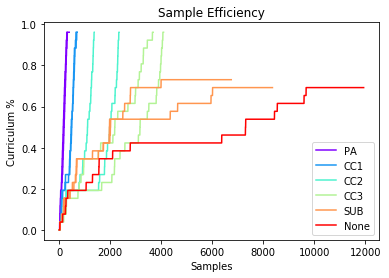

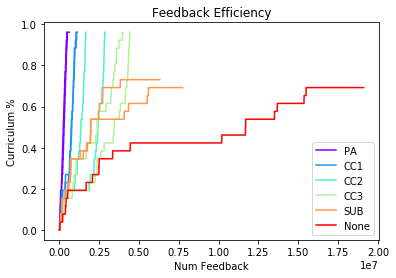

In [147]:
data_names = [
    ([539, 540], 'PA'),
    ([541, 542], 'CC1'),
    ([543, 544], 'CC2'),
    ([545, 546], 'CC3'),
    ([547, 548], 'SUB'),
    ([481], 'None'),  # TODO: SWITCH THIS OUT FOR THE ONES ON C3!!!
]

plot_curriculum(data_names, 'samples')

plot_curriculum(data_names, 'feedback')

# Claim 1: all forms of feedback help the agent learn a policy which does NOT require feedback than no teacher

This should be true, so long as the agent actually completes the curriculum, since the version w/o teacher does not.

If this isn't true for certain higher-level teachers that's fine, so long as we are able to show that the problem is grounding, but once grounded it does work better.

### GOOD NEWS: All agents trained with feedback outperform no teacher.

### BAD NEWS: Agents trained with complex teachers have a hard time completing the curriculum.

Although interestingly, CC2 and Subgoal beat the level where they got stuck when trained with no teacher! Seems like the self-distillation process actually helped the policy.

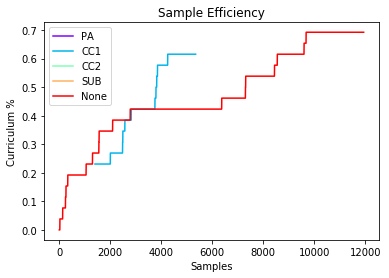

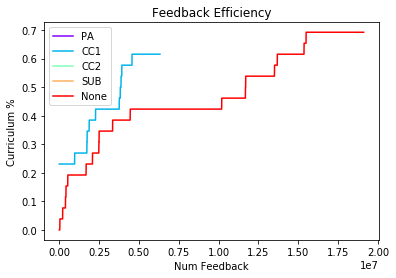

In [145]:
data_names = [  # TODO: re-run these 
    ([482], 'PA'),
    ([483], 'CC1'),
    ([484], 'CC2'),
    ([485], 'SUB'),
    ([481], 'None'),
]
plot_curriculum(data_names, 'samples')

plot_curriculum(data_names, 'feedback')

# Claim 2: Policies conditioned on feedback can generalize zero-shot (or few-shot) to performing new tasks with the teacher.
(The new levels should not have any new feedback vocabulary.)

### GOOD NEWS: all the teachers outperform not having a teacher
### BAD NEWS: the higher-level teachers are way worse than the easy teacher... we should find a way to learn those better.


In [152]:
def plot_final_generalization(runs, title):
    legend_list = []
    env_names = None
    env_dict = {}
    for run_name, legend_name in runs:
        for data_dir in data_dirs:
            for exp_dir in data_dir.iterdir():
                if run_name in exp_dir.name:
                    data = pd.read_csv(exp_dir.joinpath('results.csv'))
                    if env_names is None:
                        env_names = data[' env'].to_numpy()
                        env_dict = {env_name: [] for env_name in env_names}
                    success = data['success_rate'].to_numpy()
                    for i, (env_name, env_list) in enumerate(env_dict.items()):
                        env_list.append(success[i].item())
                    legend_list.append(legend_name)
    for env_name, env_list in env_dict.items():
        plt.title(title + ' - ' + env_name)
        plt.bar(legend_list, env_list)
        plt.show()
                    


CURRENT PROBLEMS

PA - Teacher itself is failing??

CC1 - Beautiful and awesome. Unclear why it doesn't run into the same problems as PA

CC2 - can't open doors??

CC3 - wanders randomly

CC4 - wanders randomly/spins in circles

SUB - spins in circles

NONE - A bit of wandering, but also doesn't want to open doors.

TODO: check existing door levels in the train set. Maybe it just forgot them and we need curriculum smoothing?



In [ ]:
runs = [
    ('EVAL_PA_LOWD', 'PA'),
    ('EVAL_CC1_LOWD', 'CC1'),
    ('EVAL_CC2_LOWD', 'CC2'),
    ('EVAL_CC3_LOWD', 'CC3'),
    ('EVAL_CC4_LOWD', 'CC4'),
    ('EVAL_SUB_LOWD', 'SUB'),
    ('EVAL_NONE_LOWD', 'NONE'),
    ('EVAL_BOOTSTRAP_CC2_ONLY', 'CC2_B'),
    ('EVAL_BOOTSTRAP_CC3_ONLY', 'CC3_B'),
    ('EVAL_BOOTSTRAP_SUB_ONLY', 'SUB_B'),
]

plot_final_generalization(runs, 'Eval with Teacher')

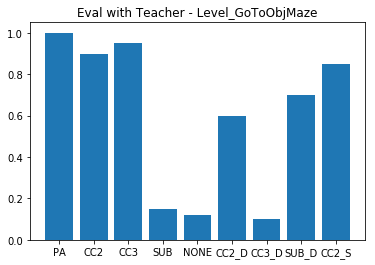

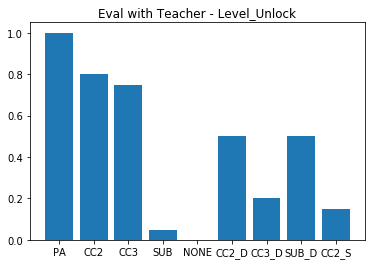

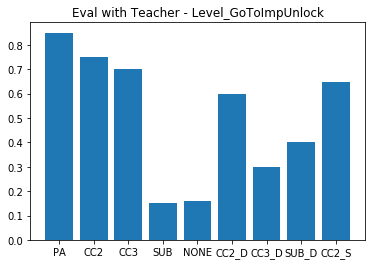

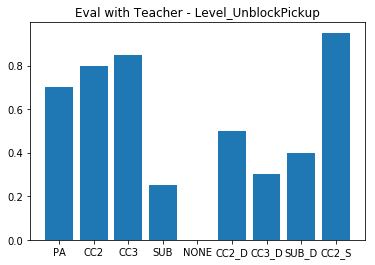

In [160]:
runs = [
    ('EVAL_539', 'PA'),
    ('EVAL_541', 'CC1'),
    ('EVAL_543', 'CC2'),
    ('EVAL_545', 'CC3'),
    ('EVAL_547', 'SUB'),
    ('EVAL_NONE_LOWD', 'NONE'),
    ('EVAL_557', 'CC2_D'),
    ('EVAL_559', 'CC3_D'),
    ('EVAL_561', 'SUB_D'),
    ('EVAL_563', 'CC2_S'),
#     ('EVAL_565', 'PA->CC3_S'),
    ('EVAL_567', 'SUB_S'),
]

plot_final_generalization(runs, 'Eval with Teacher')

# Claim 3: With the distillation process, we can generalize to performing new tasks without using the reward. This process is more feedback-efficient than just providing rewards.

TODO!

# Claim 4: Lower-level communication is more sample-efficient + feedback-efficient to ground than higher-level.

The goal is to motivate why we want to bootstrap rather than using the higher-level teachers directly.

TODO

This is true from what we've seen so far. We could probably show this in a graph by training an agent (either on the start of the curriculum or on a certain level), and checking periodically whether it can solve the held-out levels. The easy teachers should be able to do this more quickly than the harder teachers.

# Claim 5: Higher level communication is most feedback-efficient on new levels once grounded.

The goal is to motivate why we want higher-level teachers at all.

It's definitly not true so far, since the agent isn't learning to follow the higher-level teachers very accurately. We should find a way to fix this.

TODO

# Claim 6: We can ground higher-level feedback using lower-level feedback and minimal use of the reward. This is more efficient than grounding the higher-level communication directly.

Goal is to show that bootstrapping is a reasonable thing to do.

May also help with grounding harder teachers better.

TODO

Failures:
    
520 - a bunch of small things, e.g. sometimes gets stuck in room since something blocks the door. Sometimes doesn't pick up the object even when it's really near.

Also, Drollout/Advance is the main bottleneck, but Train/Advance also isn't great. (Success isn't always quite good enough), even though accuracy is pretty good.

## Comparing the Feedback Efficiency of 
### (a) Train on higher-level teacher directly
### (b) Train with easy teacher, distill to higher-level teacher
### (c) Start training on easy teacher, then distill from easy to higher-level teacher, than train with higher-level teacher

In all cases, the agent advances to the next curriculum level when it can perform well on the highest-level teacher currently provided.

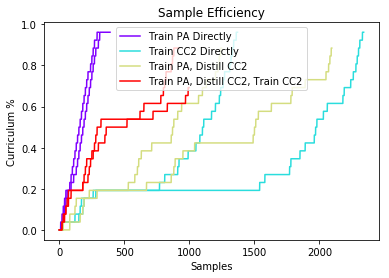

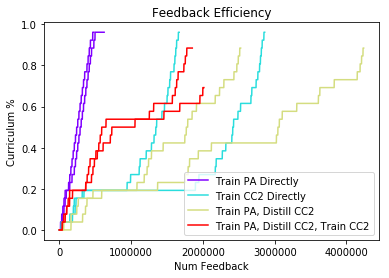

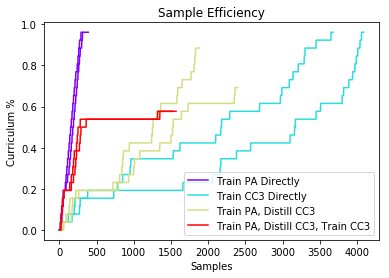

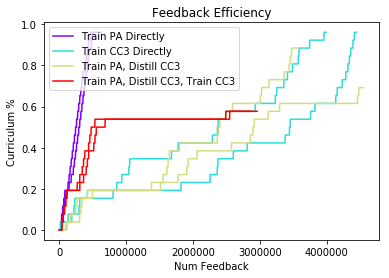

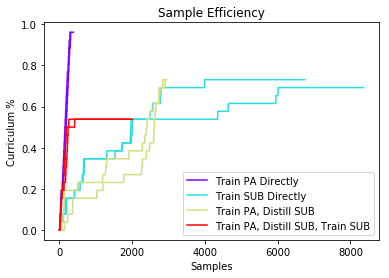

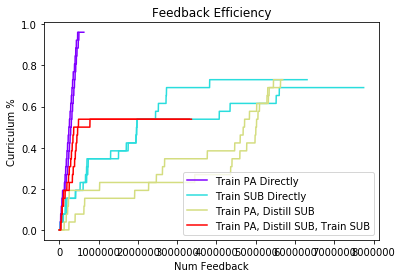

In [150]:
data_names = [
    ([539, 540], 'Train PA Directly'),
    ([543, 544], 'Train CC2 Directly'),
    ([557, 558], 'Train PA, Distill CC2'),
    ([563, 564], 'Train PA, Distill CC2, Train CC2'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [
    ([539, 540], 'Train PA Directly'),
    ([545, 546], 'Train CC3 Directly'),
    ([559, 560], 'Train PA, Distill CC3'),
    ([565, 566], 'Train PA, Distill CC3, Train CC3'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [
    ([539, 540], 'Train PA Directly'),
    ([547, 548], 'Train SUB Directly'),
    ([561, 562], 'Train PA, Distill SUB'),
    ([567, 568], 'Train PA, Distill SUB, Train SUB'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')


# Leaderboard - Curriculum Learning

Keep track of the current best methods of learning a curriculum (ranked by feedback-efficiency).

['437 - Distill from PA, Default'] [6289600.0]


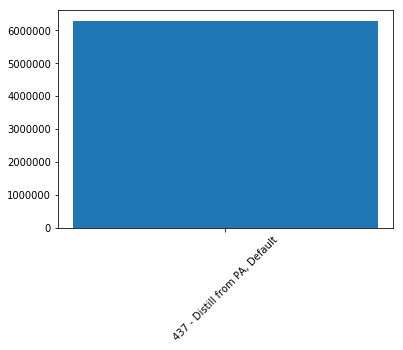

In [106]:
methods = [
    (437, "Distill from PA, Default", "Standard HParams, train PA, distill to powerset"), # TODO: placeholder; hasn't actually succeeded yet
]

plot_values = []
plot_names = []
for run_name, legend_name, _ in methods:
    try:
        data = load_data(run_name)
        num_feedback_key = 'Train/NumFeedbackTotal'
        num_feedback = np.mean([df[num_feedback_key].to_numpy()[-1].item() for df in data])
        plot_values.append(num_feedback)
        plot_names.append(f'{run_name} - {legend_name}')
    except:
        print("couldn't plot " + legend_name)
print(plot_names, plot_values)
plt.bar(plot_names, plot_values)
plt.xticks(rotation=45)
plt.show()


# Leaderboard - Few-Shot Generalization


Keep track of the current best methods of few-shot learning heldout levels (ranked by feedback-efficiency).

TODO